In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import traceback

In [4]:
mitig = pd.read_csv("mitigation_cleaned.csv")
country = pd.read_csv("Google_US_only_cleaned.csv")
states_only = pd.read_csv("Google_US_and_states_cleaned.csv")

In [5]:
# convert date columns in each data set to be datetime objects
country.loc[:,'date'] = pd.to_datetime(country['date'])
states_only.loc[:,'date'] = pd.to_datetime(states_only['date'])
mitig.loc[:,'Date'] = pd.to_datetime(mitig['Date'])


In [6]:
mitig = mitig[mitig["County"].isna()] # remove entries related to counties

In [7]:
# Find the minimum mobility value in a window after a mitigation event - US only

window_length = 5
window = np.timedelta64(window_length,'D')
google_mob_categories = country.columns[-6:] # mobility data categories


first_date = country["date"].iloc[0]
last_date = country["date"].iloc[-1]

lowest_mobility_val = []
    
# select rows in USA after earliest date  and before last date in google data from mitigation data
us_only = mitig.loc[(mitig["State"] == "USA")]
us_only = us_only.loc[(us_only["Date"] > first_date) & (us_only["Date"] < (last_date - window))]

for i,date in enumerate(us_only["Date"]):
    new_row = {"state": "USA"}
    new_row.update({"mitigation_date": date})
    new_row.update({"mitigation_type": us_only["Mitigation type"].iloc[i]})

    # get min value from each google mob category
    for cat in google_mob_categories:
        short_cat_name = cat[:-29]
        
        # get row index of min value in category for country between mitigation date and date + window
        where = country.loc[(country["date"] >= date) & (country["date"] < date + window)][cat].idxmin()
        # add the drop value
        idx = country.index[country["date"] == date]
        mob_at_event = country[cat].iloc[idx].values[0] # mobility for category at the date of mitigation event
        val = country[cat].iloc[where] - mob_at_event
#         print(f"{country[cat].iloc[where]} - {mob_at_event} = {val}")
        new_row.update({"drop_" + short_cat_name: val})
        # add the date of the value
        min_date = country["date"].iloc[where]
        new_row.update({"date_of_min_" + short_cat_name: min_date})
        #a add the delay
        delay = min_date - date
        new_row.update({"delay_" + short_cat_name: delay.days})
    lowest_mobility_val.append(new_row);
    
lowest_mobility_vals_US = DataFrame(lowest_mobility_val)
                                                   

In [8]:
lowest_mobility_vals_US

,state,mitigation_date,mitigation_type,drop_retail_and_recreation,date_of_min_retail_and_recreation,delay_retail_and_recreation,drop_grocery_and_pharmacy,date_of_min_grocery_and_pharmacy,delay_grocery_and_pharmacy,drop_parks,...,delay_parks,drop_transit_stations,date_of_min_transit_stations,delay_transit_stations,drop_workplaces,date_of_min_workplaces,delay_workplaces,drop_residential,date_of_min_residential,delay_residential
0,USA,2020-02-28,other,-1.0,2020-03-02,3,0.0,2020-02-28,0,0.0,...,0,-3.0,2020-03-02,3,0.0,2020-02-28,0,-1.0,2020-02-29,1
1,USA,2020-02-29,movement restriction,-5.0,2020-03-02,2,-1.0,2020-03-02,2,-11.0,...,2,-5.0,2020-03-02,2,-2.0,2020-03-03,3,0.0,2020-02-29,0
2,USA,2020-03-03,other,-6.0,2020-03-06,3,-7.0,2020-03-06,3,-8.0,...,3,-1.0,2020-03-04,1,0.0,2020-03-03,0,0.0,2020-03-03,0
3,USA,2020-03-06,other,0.0,2020-03-06,0,0.0,2020-03-06,0,0.0,...,0,-5.0,2020-03-10,4,-4.0,2020-03-10,4,0.0,2020-03-06,0
4,USA,2020-03-11,movement restriction,-17.0,2020-03-15,4,0.0,2020-03-11,0,-23.0,...,3,-11.0,2020-03-15,4,-6.0,2020-03-13,2,0.0,2020-03-11,0
5,USA,2020-03-11,movement restriction,-17.0,2020-03-15,4,0.0,2020-03-11,0,-23.0,...,3,-11.0,2020-03-15,4,-6.0,2020-03-13,2,0.0,2020-03-11,0
6,USA,2020-03-13,movement restriction,-20.0,2020-03-17,4,-14.0,2020-03-15,2,-5.0,...,3,-16.0,2020-03-17,4,-20.0,2020-03-17,4,0.0,2020-03-13,0
7,USA,2020-03-13,state of emergency,-20.0,2020-03-17,4,-14.0,2020-03-15,2,-5.0,...,3,-16.0,2020-03-17,4,-20.0,2020-03-17,4,0.0,2020-03-13,0
8,USA,2020-03-15,movement restriction,-19.0,2020-03-19,4,-5.0,2020-03-19,4,-6.0,...,1,-23.0,2020-03-19,4,-26.0,2020-03-19,4,0.0,2020-03-15,0
9,USA,2020-03-15,events cancelled,-19.0,2020-03-19,4,-5.0,2020-03-19,4,-6.0,...,1,-23.0,2020-03-19,4,-26.0,2020-03-19,4,0.0,2020-03-15,0


In [9]:
# Find the minimum mobility value in a window after a mitigation event - States only
window_length = 5
window = np.timedelta64(window_length,'D')
google_mob_categories = states_only.columns[-6:] # mobility data categories


first_date = states_only["date"].unique()[0]
last_date = states_only["date"].unique()[-1]


lowest_mobility_val = []


# Lookup states from google data, remove district of columbia
states = states_only["sub_region_1"].unique()
states = np.delete(states, np.where(states == "District of Columbia"))

for state in states:
    # select rows in region after earliest date  and before last date in google data from mitigation data
    mitig_cur_state = mitig.loc[(mitig["State"] == state)]
    mitig_cur_state = mitig_cur_state.loc[(mitig_cur_state["Date"] >= first_date) & (mitig_cur_state["Date"] < (last_date - window))]
    
    mob_cur_state = states_only.loc[states_only["sub_region_1"] == state]
    mob_cur_state = mob_cur_state.loc[(mob_cur_state["date"] >= first_date) & (mob_cur_state["date"] < (last_date - window))]
    try:
        for i,date in enumerate(mitig_cur_state["Date"]):
            new_row = {"state": state}
            new_row.update({"mitigation_date": date})
            new_row.update({"mitigation_type": mitig_cur_state["Mitigation type"].iloc[i]})

            # get min value from each google mob category
            for cat in google_mob_categories:
                
                short_cat_name = cat[:-29]

                # get row index of min value in category for states_only between mitigation date and date + window
                where = mob_cur_state.loc[(mob_cur_state["date"] >= date) & (mob_cur_state["date"] < date + window)][cat].idxmin()
                # add the drop value
                idx = mob_cur_state.index[mob_cur_state["date"] == date] # index of current date in current state
                mob_at_event = states_only[cat].iloc[idx].values[0] # mobility for category at the date of mitigation event
                val = states_only[cat].iloc[where] - mob_at_event
                new_row.update({"drop_" + short_cat_name: val})

                # add the date
                min_date = states_only["date"].iloc[where]
                new_row.update({"date_of_min_" + short_cat_name: min_date})
                # add the delay
                delay = min_date - date
                
                new_row.update({"delay_" + short_cat_name: delay.days})
            lowest_mobility_val.append(new_row);
    except IndexError:
        print(f"Error: {state}: {date}: {where}")
        traceback.print_exc()
    except ValueError:
        print(f"Error: {state}: {date}: {where}")
        traceback.print_exc()

lowest_mobility_vals_states = DataFrame(lowest_mobility_val)

In [10]:
lowest_mobility_vals_states

,state,mitigation_date,mitigation_type,drop_retail_and_recreation,date_of_min_retail_and_recreation,delay_retail_and_recreation,drop_grocery_and_pharmacy,date_of_min_grocery_and_pharmacy,delay_grocery_and_pharmacy,drop_parks,...,delay_parks,drop_transit_stations,date_of_min_transit_stations,delay_transit_stations,drop_workplaces,date_of_min_workplaces,delay_workplaces,drop_residential,date_of_min_residential,delay_residential
0,Alabama,2020-03-06,new public services,0.0,2020-03-06,0,0.0,2020-03-06,0,-8.0,...,4,-6.0,2020-03-10,4,-1.0,2020-03-10,4,-1.0,2020-03-07,1
1,Alabama,2020-03-11,other,-17.0,2020-03-15,4,0.0,2020-03-11,0,-11.0,...,4,-1.0,2020-03-15,4,-5.0,2020-03-15,4,0.0,2020-03-11,0
2,Alabama,2020-03-12,other,-17.0,2020-03-15,3,-6.0,2020-03-15,3,-27.0,...,3,-6.0,2020-03-16,4,-11.0,2020-03-16,4,0.0,2020-03-12,0
3,Alabama,2020-03-12,events cancelled,-17.0,2020-03-15,3,-6.0,2020-03-15,3,-27.0,...,3,-6.0,2020-03-16,4,-11.0,2020-03-16,4,0.0,2020-03-12,0
4,Alabama,2020-03-12,school closing,-17.0,2020-03-15,3,-6.0,2020-03-15,3,-27.0,...,3,-6.0,2020-03-16,4,-11.0,2020-03-16,4,0.0,2020-03-12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,Wyoming,2020-03-27,other,-2.0,2020-03-28,1,-5.0,2020-03-29,2,-5.0,...,1,-1.0,2020-03-29,2,-1.0,2020-03-31,4,-9.0,2020-03-29,2
1583,Wyoming,2020-03-27,new public services,-2.0,2020-03-28,1,-5.0,2020-03-29,2,-5.0,...,1,-1.0,2020-03-29,2,-1.0,2020-03-31,4,-9.0,2020-03-29,2
1584,Wyoming,2020-03-27,other,-2.0,2020-03-28,1,-5.0,2020-03-29,2,-5.0,...,1,-1.0,2020-03-29,2,-1.0,2020-03-31,4,-9.0,2020-03-29,2
1585,Wyoming,2020-04-03,movement restriction,-5.0,2020-04-04,1,-8.0,2020-04-05,2,0.0,...,0,-10.0,2020-04-05,2,0.0,2020-04-03,0,-8.0,2020-04-05,2


In [11]:
cols = ['drop_retail_and_recreation', 'drop_grocery_and_pharmacy', 'drop_parks', 'drop_transit_stations', 'drop_workplaces', 'drop_residential']
for col in cols:
    print(col)
    print("\tMean mobility drop: {}".format(lowest_mobility_vals_states[col].mean()))
    print("\tVariance in mobility drop: {}".format(lowest_mobility_vals_states[col].var()))

drop_retail_and_recreation
	Mean mobility drop: -13.306238185255198
	Variance in mobility drop: 76.72330910590547
drop_grocery_and_pharmacy
	Mean mobility drop: -11.470069313169502
	Variance in mobility drop: 91.07523851978216
drop_parks
	Mean mobility drop: -30.02331442974165
	Variance in mobility drop: 982.9672997264212
drop_transit_stations
	Mean mobility drop: -10.708884688090738
	Variance in mobility drop: 49.51671168089389
drop_workplaces
	Mean mobility drop: -9.231253938248267
	Variance in mobility drop: 71.00008184404952
drop_residential
	Mean mobility drop: -2.6792690611216132
	Variance in mobility drop: 12.748895303979062


In [133]:
# mean mobility drops by mitigation type in each category
cols = ['drop_retail_and_recreation', 'drop_grocery_and_pharmacy', 'drop_parks', 'drop_transit_stations', 'drop_workplaces', 'drop_residential']
drops_table = pd.pivot_table(lowest_mobility_vals_states, values=cols, index=['mitigation_type'], aggfunc=np.mean)
drops_table

,drop_grocery_and_pharmacy,drop_parks,drop_residential,drop_retail_and_recreation,drop_transit_stations,drop_workplaces
mitigation_type,,,,,,
events cancelled,-11.612069,-32.103448,-1.008621,-17.387931,-13.948276,-12.405172
movement restriction,-11.107438,-28.842975,-1.809917,-14.396694,-10.859504,-10.115702
new public services,-10.907063,-29.386617,-3.494424,-11.167286,-9.289963,-6.933086
non-essential closing,-15.702247,-26.269663,-2.219101,-16.915730,-13.696629,-11.528090
other,-10.720982,-29.774554,-3.328125,-10.986607,-9.229911,-7.917411
public service reduction,-12.134146,-26.573171,-2.439024,-15.573171,-12.170732,-10.756098
school closing,-11.248447,-34.919255,-1.801242,-16.242236,-12.652174,-11.919255
state of emergency,-7.652174,-30.014493,-1.405797,-12.985507,-10.057971,-10.275362
stay at home,-13.404494,-35.550562,-3.179775,-12.348315,-9.325843,-6.876404


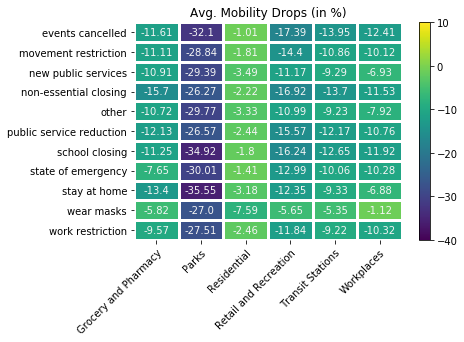

In [135]:
drops_by_events = drops_table.to_numpy()
drops_by_events = np.round(drops_by_events, decimals=2)

mob_cat = ["Grocery and Pharmacy", "Parks", "Residential", "Retail and Recreation", "Transit Stations", "Workplaces"]
mitig_types = drops_table.index
# print(len(mitig_types), drops_by_events.shape)

fig, ax = plt.subplots()
im = ax.imshow(drops_by_events, aspect='auto', cmap="viridis", vmin=-40, vmax=10)

ax.set_xticklabels(mob_cat)
ax.set_yticklabels(mitig_types)

ax.set_xticks(np.arange(len(mob_cat)))
ax.set_yticks(np.arange(len(mitig_types)))
  
# Set up white spacing between cells
ax.set_xticks(np.arange(len(mob_cat) + 1) -.5, minor=True)
ax.set_yticks(np.arange(len(mitig_types) + 1) -.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)
for edge, spine in ax.spines.items():
        spine.set_visible(False)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# add text to cells
for i in range(len(mitig_types)):
    for j in range(len(mob_cat)):
        text = ax.text(j, i, drops_by_events[i,j], ha="center", va="center", color="#f5f5f5")

ax.set_title("Avg. Mobility Drops (in %)")
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()


In [123]:
# mean delay to mobility drop by mitigation type in each category
cols = ['delay_retail_and_recreation', 'delay_grocery_and_pharmacy', 'delay_parks', 'delay_transit_stations', 'delay_workplaces', 'delay_residential']
delays_table = pd.pivot_table(lowest_mobility_vals_states, index=['mitigation_type'], values=cols, aggfunc='mean')
delays_table

,delay_grocery_and_pharmacy,delay_parks,delay_residential,delay_retail_and_recreation,delay_transit_stations,delay_workplaces
mitigation_type,,,,,,
events cancelled,2.517241,2.500000,0.655172,3.362069,3.525862,3.241379
movement restriction,2.438017,2.181818,1.181818,3.049587,3.214876,2.859504
new public services,2.267658,1.892193,1.646840,2.531599,2.579926,2.375465
non-essential closing,2.876404,2.117978,1.320225,2.994382,3.151685,2.926966
other,2.424107,1.870536,1.535714,2.631696,2.897321,2.707589
public service reduction,2.536585,2.060976,1.426829,3.304878,3.231707,3.000000
school closing,2.627329,2.236025,0.981366,3.161491,3.310559,3.223602
state of emergency,1.637681,1.739130,0.869565,2.956522,3.000000,3.086957
stay at home,2.258427,2.011236,1.842697,2.426966,2.752809,2.404494


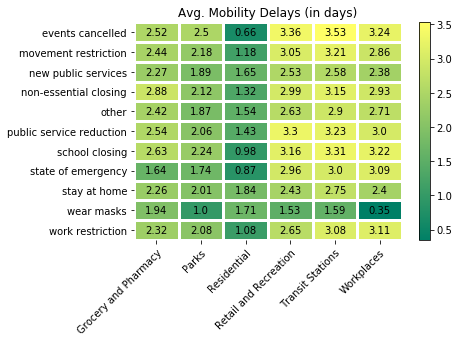

In [131]:
delays_by_events = delays_table.to_numpy()
delays_by_events = np.round(delays_by_events, decimals=2)

mob_cat = ["Grocery and Pharmacy", "Parks", "Residential", "Retail and Recreation", "Transit Stations", "Workplaces"]
mitig_types = delays_table.index

fig, ax = plt.subplots()
im = ax.imshow(delays_by_events, aspect='auto', cmap="summer")

ax.set_xticklabels(mob_cat)
ax.set_yticklabels(mitig_types)

ax.set_xticks(np.arange(len(mob_cat)))
ax.set_yticks(np.arange(len(mitig_types)))
  
# Set up white spacing between cells
ax.set_xticks(np.arange(len(mob_cat) + 1) -.5, minor=True)
ax.set_yticks(np.arange(len(mitig_types) + 1) -.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)
for edge, spine in ax.spines.items():
        spine.set_visible(False)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# add text to cells
for i in range(len(mitig_types)):
    for j in range(len(mob_cat)):
        text = ax.text(j, i, delays_by_events[i,j], ha="center", va="center", color="k")

ax.set_title("Avg. Mobility Delays (in days)")
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

In [48]:
# print("US largest drops")
# for col in lowest_mobility_vals_US.columns[3::3]:
#     print(lowest_mobility_vals_US[col].min())
# for i, state in enumerate(lowest_mobility_vals_states["state"].unique()):
#     print(f"{i}) {state} largest drops")
#     for col in lowest_mobility_vals_states.columns[3::3]:
#         where = lowest_mobility_vals_states.loc[lowest_mobility_vals_states['state'] == state][col].idxmin()
#         val = lowest_mobility_vals_states[col].iloc[where]
#         date = lowest_mobility_vals_states['mitigation_date'].iloc[where]
#         mitig_type = lowest_mobility_vals_states['mitigation_type'].iloc[where]
#         print("\t{} {}".format(col, val))
#         print("\t{} {}".format(date, mitig_type))

US largest drops
-16.0
-18.0
-28.0
-13.0
-20.0
-9.0
0) Alabama largest drops
	drop_retail_and_recreation -27.0
	2020-03-18 00:00:00 events cancelled
	drop_grocery_and_pharmacy -30.0
	2020-04-03 00:00:00 stay at home
	drop_parks -53.0
	2020-03-27 00:00:00 non-essential closing
	drop_transit_stations -19.0
	2020-03-18 00:00:00 events cancelled
	drop_workplaces -26.0
	2020-03-14 00:00:00 public service reduction
	drop_residential -7.0
	2020-03-27 00:00:00 non-essential closing
1) Alaska largest drops
	drop_retail_and_recreation -31.0
	2020-03-15 00:00:00 events cancelled
	drop_grocery_and_pharmacy -17.0
	2020-03-16 00:00:00 public service reduction
	drop_parks -59.0
	2020-03-22 00:00:00 movement restriction
	drop_transit_stations -28.0
	2020-03-15 00:00:00 events cancelled
	drop_workplaces -24.0
	2020-03-15 00:00:00 events cancelled
	drop_residential -11.0
	2020-04-03 00:00:00 wear masks
2) Arizona largest drops
	drop_retail_and_recreation -21.0
	2020-03-15 00:00:00 school closing
	drop_g

	drop_parks -66.0
	2020-03-11 00:00:00 events cancelled
	drop_transit_stations -18.0
	2020-03-18 00:00:00 non-essential closing
	drop_workplaces -26.0
	2020-03-14 00:00:00 public service reduction
	drop_residential -9.0
	2020-04-03 00:00:00 other
42) Utah largest drops
	drop_retail_and_recreation -26.0
	2020-03-16 00:00:00 school closing
	drop_grocery_and_pharmacy -24.0
	2020-03-12 00:00:00 movement restriction
	drop_parks -87.0
	2020-03-17 00:00:00 movement restriction
	drop_transit_stations -18.0
	2020-03-16 00:00:00 school closing
	drop_workplaces -23.0
	2020-03-21 00:00:00 other
	drop_residential -10.0
	2020-03-18 00:00:00 new public services
43) Vermont largest drops
	drop_retail_and_recreation -36.0
	2020-03-16 00:00:00 movement restriction
	drop_grocery_and_pharmacy -31.0
	2020-03-25 00:00:00 public service reduction
	drop_parks -68.0
	2020-03-09 00:00:00 public service reduction
	drop_transit_stations -34.0
	2020-03-11 00:00:00 events cancelled
	drop_workplaces -28.0
	2020-03-1